In [134]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import ceil

In [135]:
effect_size = sms.proportion_effectsize(0.10, 0.12)

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    ) 

required_n = ceil(required_n)
print(f'необходимый размер каждой группы: {required_n}')

необходимый размер каждой группы: 3835


In [136]:
ab = pd.read_csv('AB_Test_Results.csv', sep=',')
ab.head(15)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.00
1,2423,control,0.00
2,9411,control,0.00
3,7311,control,0.00
4,6174,variant,0.00
5,2380,variant,0.00
6,2849,control,0.00
7,9168,control,0.00
8,6205,variant,0.00
9,7548,control,0.00


In [137]:
ab.rename(columns={'USER_ID':'user_id', 'VARIANT_NAME':'group', 'REVENUE':'revenue'}, inplace=True)
ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  10000 non-null  int64  
 1   group    10000 non-null  object 
 2   revenue  10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [138]:
control_sample = ab[ab['group'] == 'control'].sample(n=required_n, random_state=0)
treatment_sample = ab[ab['group'] == 'variant'].sample(n=required_n, random_state=0)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,group,revenue
0,3916,control,0.00
1,6621,control,0.00
2,4507,control,0.00
3,5798,control,0.00
4,4647,control,0.00
...,...,...,...
7665,7754,variant,0.00
7666,9171,variant,0.00
7667,1555,variant,0.00
7668,6065,variant,7.27


In [139]:
ab_test['group'].value_counts()

control    3835
variant    3835
Name: group, dtype: int64

In [140]:
conversion_rates = ab_test.groupby('group')['revenue']

std_p = lambda x: np.std(x, ddof=0)              # Стандартное отклонение
se_p = lambda x: stats.sem(x, ddof=0)            # Стандартная ошибка

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['mean_revenue', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,mean_revenue,std_deviation,std_error
group,,,
control,0.143,3.394,0.055
variant,0.078,1.469,0.024


Text(0, 0.5, 'Mean revenue')

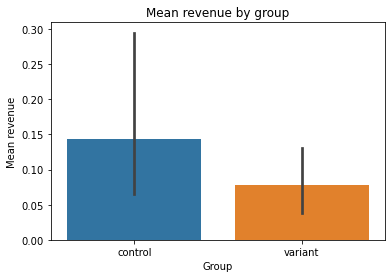

In [141]:
import seaborn as sns

sns.barplot(x=ab_test['group'], y=ab_test['revenue'])
plt.title('Mean revenue by group')
plt.xlabel('Group')
plt.ylabel('Mean revenue')

In [142]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['group'] == 'control']['revenue']
treatment_results = ab_test[ab_test['group'] == 'variant']['revenue']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 9.14
p-value: 0.000
ci 95% for control group: [0.132, 0.154]
ci 95% for treatment group: [0.069, 0.086]


In [143]:
print(f'p-value = {pval} > 0.05 - the groups do not differ statistically significantly')

p-value = 6.366407880559996e-20 > 0.05 - the groups do not differ statistically significantly


In [144]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['group'] == 'control']['revenue']
treatment_results = ab_test[ab_test['group'] == 'variant']['revenue']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 9.14
p-value: 0.000
ci 95% for control group: [0.132, 0.154]
ci 95% for treatment group: [0.069, 0.086]


 **Делаем вывод.** В нашем случае p-value = 0.000, что меньше 0.05. Поэтому мы можем отклонить нулевую гипотезу, то есть наши группы статистически значимо различаются.